### CREATE DAILY INPUT FOR THE ML MODEL

Input:
- the measured runoff at the gauging station,
- the catchment area of the gauging station,
- the ERA5 datasets for Potential Evapotranspiration, Temperature and Precipitation.

Output:
    - a .csv file is saved in conda/daily_input folder.

In [1]:
from create_daily_csv import interpolate_df,readnetcdf_in_shp,xarray2df,check_data_gap
import pandas as pd
import numpy as np
import os

In [2]:
shp_catchment_path = r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\qgis\final_delineation'
shp_catchment_fileName =shp_catchment_path + r'\ADIGE_BRONZOLO.shp'

In [3]:
# Runoff
catchment_name = 'CANDOGLIA_TOCE_2000_2019.csv'
fileName = r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\data_discharge\\' + catchment_name
#runoff = pd.read_csv(fileName, index_col=2, parse_dates=True)
runoff = pd.read_csv(fileName, delimiter=',', index_col=1
                     , parse_dates=True)

runoff['discharge_m3_s']=runoff['pretok (m3/s)']
runoff=runoff.drop(columns='pretok (m3/s)')

runoff=runoff.drop(columns='temp. vode (°C)')

In [5]:
check_data_gap(runoff)
runoff = runoff.reindex(pd.date_range(runoff.index.min() - pd.DateOffset(years=1), runoff.index.max()), fill_value=np.nan)
runoff = runoff.rename(columns={'discharge_m3_s': 'Q'})
runoff.drop(['id_station','quality'],axis=1,inplace=True)

Date start: 2000-01-01, date end: 2019-12-31
No missing dates


In [ ]:
# ERA5 temperature

era5_fileName=  r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\era5\2m_temperature-19790101_20181231-eusalp-qm_era5.nc'

t2m = readnetcdf_in_shp(era5_fileName,shp_catchment_fileName,plot=True,res=5500)['t2m']

n of pixels287
Date start: 1979-01-01, date end: 2018-12-31
No missing dates


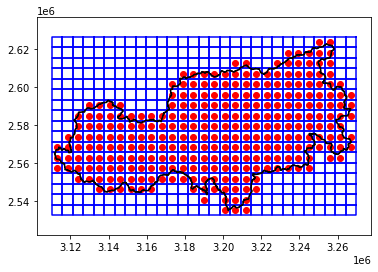

In [3]:
t2m = xarray2df(t2m.resample(time='1d').mean(), 'T','t2m')

check_data_gap(t2m)

In [7]:
t2m.shape

(14610, 75)

n of pixels75
Date start: 1979-01-01, date end: 2018-12-31
No missing dates


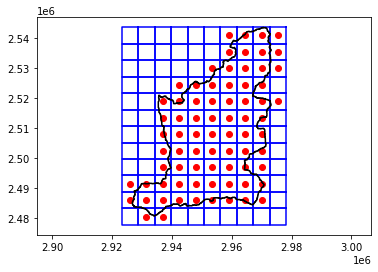

In [8]:
# ERA5 evapotranspiration
era5_fileName = r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\era5\potential_evapotranspiration-19790101_20181231-eusalp-qm_era5.nc'

pet = readnetcdf_in_shp(era5_fileName, shp_catchment_fileName,plot=True)['pet']
pet = xarray2df(pet.resample(time='1d').sum(skipna=False), 'E','pet')

check_data_gap(pet)

n of pixels75
Date start: 1979-01-01, date end: 2018-12-31
No missing dates


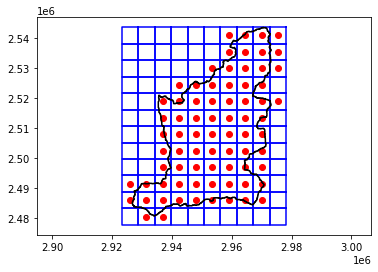

In [9]:
# ERA5 total precipitation
era5_fileName = r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\era5\total_precipitation-19790101_20181231-eusalp-qm_era5.nc'

tp = readnetcdf_in_shp(era5_fileName, shp_catchment_fileName,plot=True)['tp']
tp = xarray2df(tp.resample(time='1d').sum(skipna=False), 'P','tp')

check_data_gap(tp)

In [10]:
# Concatenate and save
daily_input = pd.concat([runoff, t2m, tp, pet], axis=1, join='inner')
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\\'+catchment_name
#save into a csv file.
# if file does not exist write header 
if not os.path.isfile(path):
   daily_input.to_csv(path)
else: # else print the problem
   print('file already exists')